The main purpose of this file is to tweak parameters for the Multiple Tracker.
There is also test code for additional features that can be ignored

In [1]:
#boiler plate
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

%pylab inline
import numpy as np
import pandas as pdz
from pandas import DataFrame, Series  # for convenience
from IPython.display import HTML #this is for generating python videos
import pims
import trackpy as tp
import av
import os

@pims.pipeline
def grey(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

@pims.pipeline
def crop(image,xmin,xmax,ymin,ymax): #this needs to be a pims.pipeline or its unhappy with usual python notation
    return image[xmin:xmax,ymin:ymax]

Populating the interactive namespace from numpy and matplotlib


In [2]:
#import the image and display info
filename = "Z-stack_2020-10-09_13.58.59-006.ims - C=0.tif"
path = os.path.join(sys.path[0], filename)
frames = pims.open(path)
#frames = grey(frames) #converts to grey for rgb images
#frames = crop(frames,0,1000,0,1000) #crops out part of the image
frames

<Frames>
Source: c:\Users\jmlan\OneDrive - North Carolina State University\Desktop\91020\C0\Z-stack_2020-10-09_13.58.59-006.ims - C=0.tif
Length: 200 frames
Frame Shape: (2048, 2048)
Pixel Datatype: uint16

Frame([[104, 104, 105, ..., 106, 108, 104],
       [105, 103, 102, ..., 102, 102, 103],
       [107, 103, 104, ..., 106, 103, 104],
       ...,
       [106, 107, 106, ..., 104, 107, 104],
       [105, 104, 103, ..., 107, 105, 106],
       [106, 106, 106, ..., 104, 103, 104]], dtype=uint16)
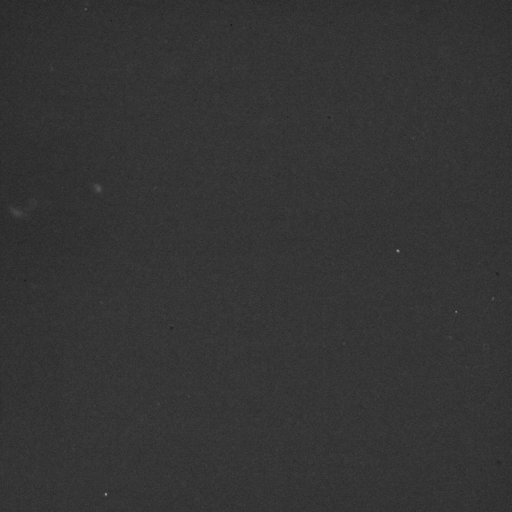

In [3]:
#show first frame
frames[0]

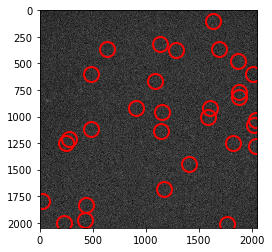

In [4]:
#adjust tracking on the first frame here
%matplotlib inline

### copy this into Multiple Code after finding parameters that work ###
minmass = 18 #scales with the size
maxsize = 15
noise_size = 3
aproxsize = 5 #must be odd
#######################################################################

f = tp.locate(frames[0], 
    aproxsize, 
    invert=False, 
    minmass=minmass, 
    maxsize=maxsize, 
    #noise_size=noise_size, 
    engine='numba')
tp.annotate(f, frames[0])

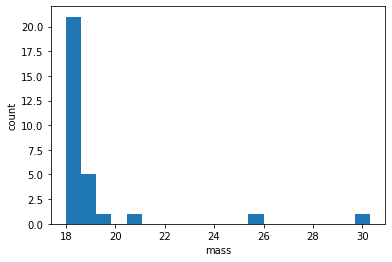

In [12]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [15]:
#Runs Tracking for all frames
f = tp.batch(frames, 5, invert=True, minmass=minmass, maxsize=maxsize, noise_size=noise_size, engine='numba')
#f.head() #displays tabulated data

Frame 196: 12 features


In [90]:
#link the frames together
t1 = tp.link(f, #link them together
    100, #search distance
    memory=5) #number of frames feature can disapear for
t1.head() #print link results

#filter and plot trajectories
t1 = tp.filter_stubs(t1, 5) #gets rid of small trajectories
tp.plot_traj(t1); #plotting pretty lines

Frame 199: 1 trajectories present.


y            x        mass      size       ecc     signal  \
0   866.029367   451.125271  108.345180  1.438953  0.084732  10.227471   
1   869.990879   470.047539  112.078885  1.433937  0.097991   9.870973   
2   190.985675  1064.025419  164.713388  1.415214  0.101461  14.989852   
3  1305.903103  1731.992764  126.433285  1.411324  0.109352  12.562564   
4  1662.929248  1770.049677  102.894403  1.419167  0.059713   9.476761   

   raw_mass        ep  frame  particle  
0  849654.0 -0.171265      1         0  
1  849636.0 -0.159701      2         0  
2  849502.0 -0.107726      4         1  
3  849608.0 -0.145127      4         2  
4  849643.0 -0.163918      4         3

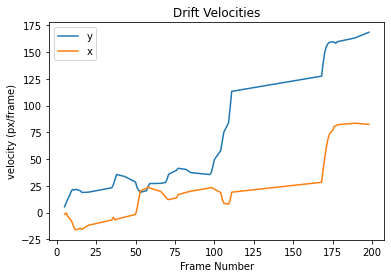

In [93]:
#plotting drift
%matplotlib inline
d = tp.compute_drift(t1, smoothing = 5) #find drift
d.plot()
plt.xlabel("Frame Number")
plt.ylabel("velocity (px/frame)")
plt.title("Drift Velocities")
plt.show()

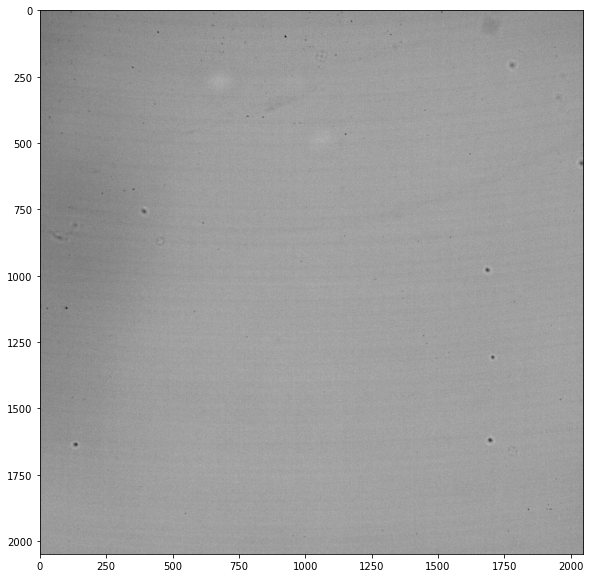

In [127]:
# animates the figure, very memory intensive and slow
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

fig = plt.figure(figsize=(10,10))
im = fig.add_subplot()
im.imshow(frames[0])

def animate_func(i):
    im.clear()
    im.imshow(frames[i])
    return [im]
anim = animation.FuncAnimation(fig, animate_func, frames=len(frames), interval=100); #change interval to change the default frame time
HTML(anim.to_jshtml())

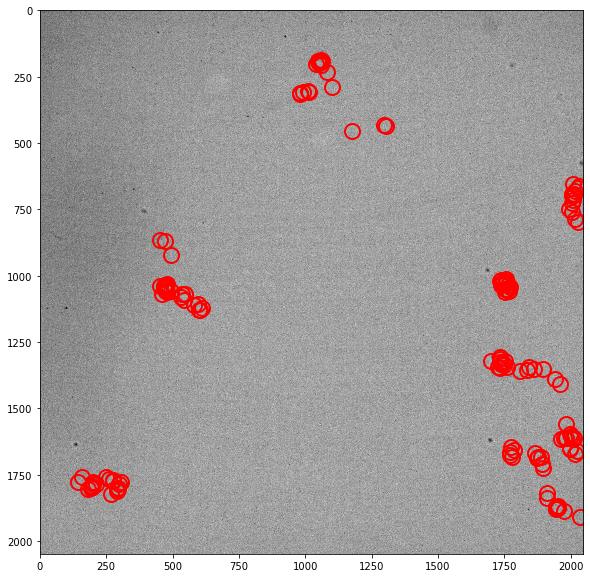

TypeError: __init__() got an unexpected keyword argument 'frames'

In [133]:
#This block attempts to make a video of the annotated frames
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

#fig = plt.figure(figsize=(10,10))
fig = plt.figure(figsize=(10,10))
im = fig.add_subplot()
im = tp.annotate(f, frames[0])

def animate_func(i):
    im.clear()
    im = tp.annotate(f, frames[i])
    return [im]
    
anim = animation.ArtistAnimation(fig, animate_func, frames=len(frames)/2, interval=100); #change interval to change the default frame time
HTML(anim.to_jshtml())